In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
data_dir = r"D:\Desktop\Cd rive All with project\MS-projects\Hindko Spoken Digits\images-Dataset - Copy"

In [3]:
import pathlib
data_dir = pathlib.Path(data_dir)

In [4]:
image_count_train = len(list(data_dir.glob('*/*.png')))
print(image_count_train)

1332


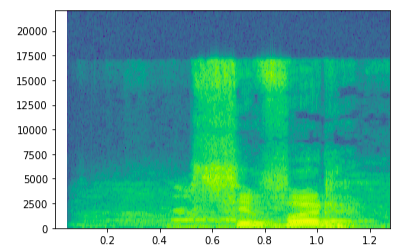

In [5]:
zero = list(data_dir.glob('0/*'))
PIL.Image.open(str(zero[0]))

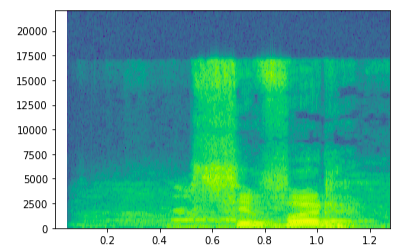

In [6]:
PIL.Image.open(str(zero[1]))

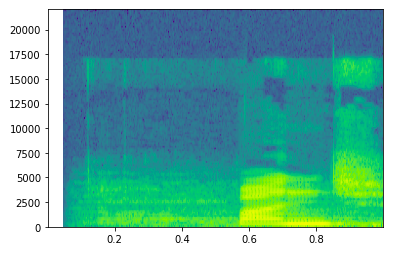

In [7]:
five = list(data_dir.glob('5/*'))
PIL.Image.open(str(five[0]))

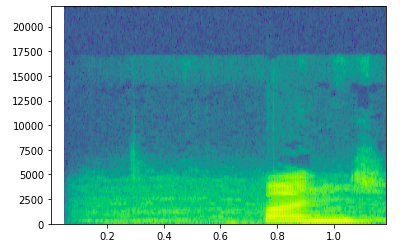

In [8]:
PIL.Image.open(str(five[7]))

In [9]:
batch_size = 32
img_height = 150
img_width = 150

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1332 files belonging to 10 classes.
Using 1066 files for training.


In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1332 files belonging to 10 classes.
Using 266 files for validation.


In [12]:
class_names = train_ds.class_names
print(class_names)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


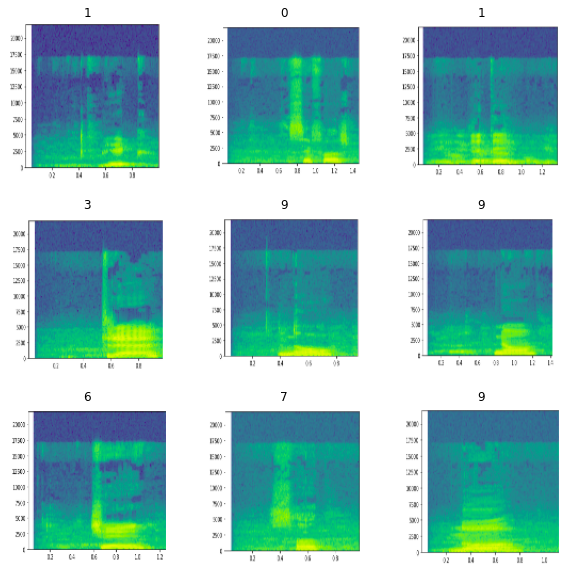

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 150, 150, 3)
(32,)


In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
normalization_layer = layers.Rescaling(1./255)

In [17]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [18]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

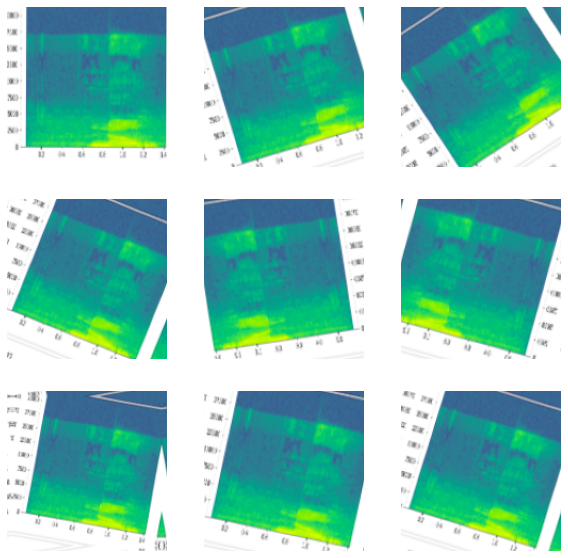

In [19]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [20]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(10, name="outputs")
])

In [21]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                  

In [23]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best_CNN_80_20_1.hdf5',
                                  save_best_only=True,
                                  verbose=1)

In [24]:
epochs = 35
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks = [tl_checkpoint_1]
)

Epoch 1/35
34/34 [==============================] - ETA: 0s - loss: 2.4325 - accuracy: 0.1304
Epoch 1: val_loss improved from inf to 2.30248, saving model to tl_model_v1.weights.best_CNN_80_20_1.hdf5
34/34 [==============================] - 28s 726ms/step - loss: 2.4325 - accuracy: 0.1304 - val_loss: 2.3025 - val_accuracy: 0.0977
Epoch 2/35
34/34 [==============================] - ETA: 0s - loss: 2.2812 - accuracy: 0.1463
Epoch 2: val_loss improved from 2.30248 to 2.27792, saving model to tl_model_v1.weights.best_CNN_80_20_1.hdf5
34/34 [==============================] - 24s 711ms/step - loss: 2.2812 - accuracy: 0.1463 - val_loss: 2.2779 - val_accuracy: 0.2143
Epoch 3/35
34/34 [==============================] - ETA: 0s - loss: 2.2220 - accuracy: 0.2261
Epoch 3: val_loss improved from 2.27792 to 2.09933, saving model to tl_model_v1.weights.best_CNN_80_20_1.hdf5
34/34 [==============================] - 24s 722ms/step - loss: 2.2220 - accuracy: 0.2261 - val_loss: 2.0993 - val_accuracy: 0.2

34/34 [==============================] - 25s 731ms/step - loss: 0.4488 - accuracy: 0.8405 - val_loss: 0.2970 - val_accuracy: 0.8910
Epoch 19/35
34/34 [==============================] - ETA: 0s - loss: 0.4067 - accuracy: 0.8621
Epoch 19: val_loss improved from 0.29697 to 0.28944, saving model to tl_model_v1.weights.best_CNN_80_20_1.hdf5
34/34 [==============================] - 24s 705ms/step - loss: 0.4067 - accuracy: 0.8621 - val_loss: 0.2894 - val_accuracy: 0.9361
Epoch 20/35
34/34 [==============================] - ETA: 0s - loss: 0.3353 - accuracy: 0.8856
Epoch 20: val_loss improved from 0.28944 to 0.19001, saving model to tl_model_v1.weights.best_CNN_80_20_1.hdf5
34/34 [==============================] - 24s 709ms/step - loss: 0.3353 - accuracy: 0.8856 - val_loss: 0.1900 - val_accuracy: 0.9474
Epoch 21/35
34/34 [==============================] - ETA: 0s - loss: 0.3040 - accuracy: 0.8931
Epoch 21: val_loss improved from 0.19001 to 0.18048, saving model to tl_model_v1.weights.best_CNN

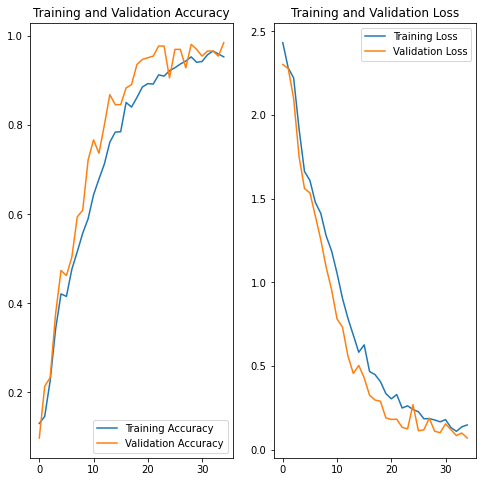

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [1]:
from keras.preprocessing.image import ImageDataGenerator
import os
from keras.applications.vgg16 import VGG16, preprocess_input
test_data_dir = r"D:\Desktop\Cd rive All with project\MS\Aneqa\trainingSample\data\val"
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input) 
testgen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=(150, 150),
                                             class_mode=None,
                                             classes=class_subset,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

Found 403 images belonging to 10 classes.


In [2]:
train = r"D:\Desktop\Cd rive All with project\MS-projects\Hindko Spoken Digits\data_distribution\data_distribution8-30\train"
BATCH_SIZE = 64

train_generator = ImageDataGenerator(rotation_range=90, 
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5, 
                                     height_shift_range=0.5,
                                     horizontal_flip=True, 
                                     vertical_flip=True,
                                     validation_split=0.15,
                                     preprocessing_function=preprocess_input)
traingen = train_generator.flow_from_directory(train,
                                               target_size=(150, 150),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='training',
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

Found 794 images belonging to 10 classes.


In [ ]:
#"D:\Desktop\Cd rive All with project\MS-projects\Hindko Spoken Digits\implementation\tl_model_v1.weights.best_CNN.hdf5"

In [8]:
# Generate predictions
from keras.models import load_model
import numpy as np
model = load_model('tl_model_v1.weights.best_CNN.hdf5')
#model.load_weights('tl_model_v1.weights.best_CNN_80_20_1.hdf5') # initialize the best trained weights

true_classes = testgen.classes
class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

vgg_preds = model.predict(testgen)
vgg_pred_classes = np.argmax(vgg_preds, axis=1)

ValueError: Unknown metric function: specificity. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

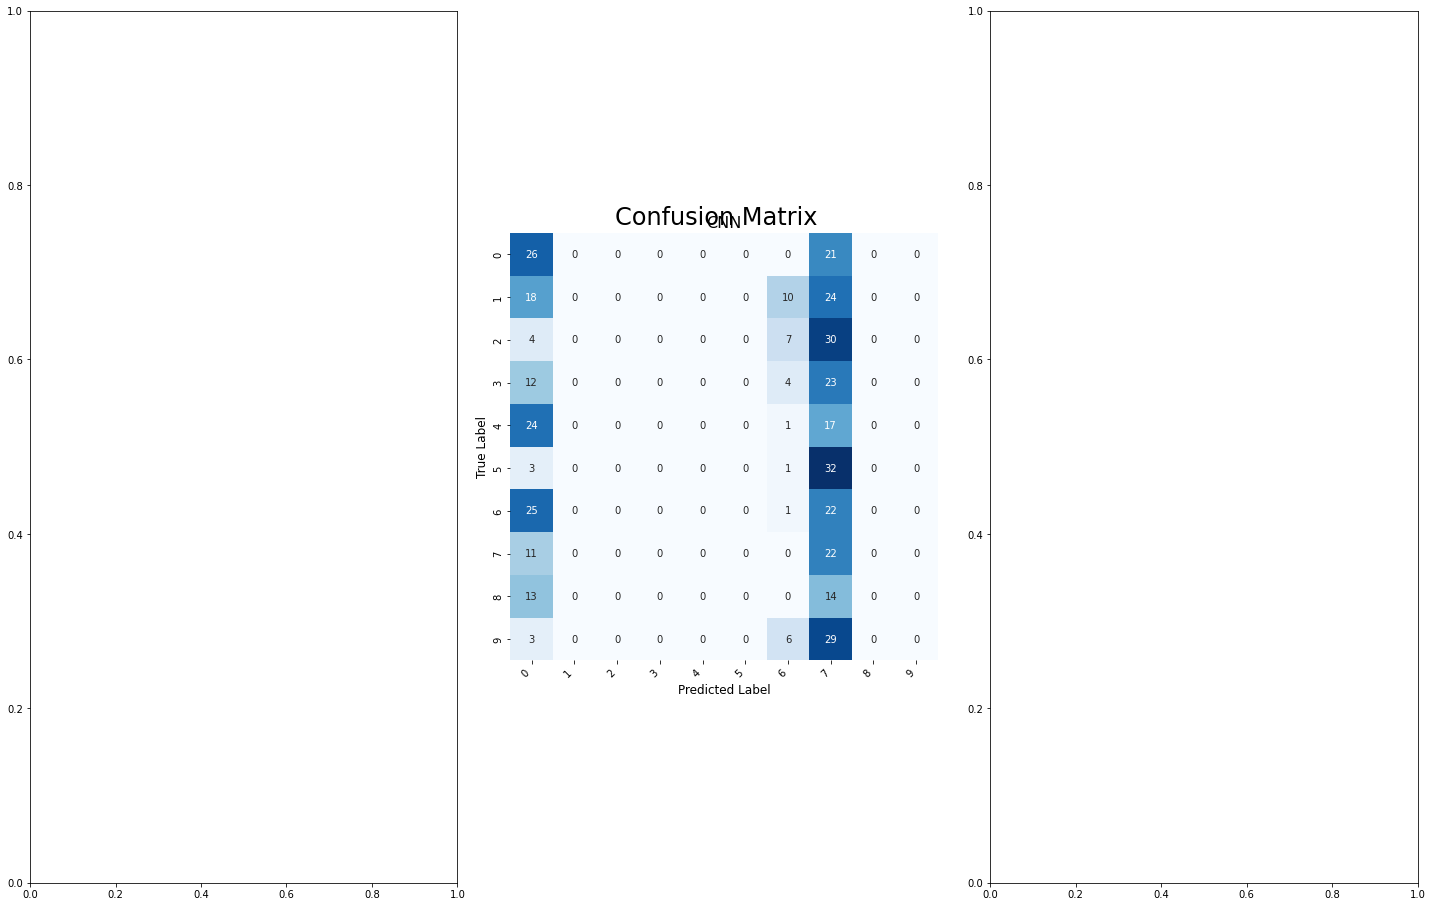

In [7]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
# Get the names of the ten classes
class_names = testgen.class_indices.keys()

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))

plot_heatmap(true_classes, vgg_pred_classes, class_names, ax2, title="CNN")    

fig.suptitle("Confusion Matrix", fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=1.25)
plt.show()